In [1]:
import numpy as np
import pandas as pd
import polars as pl 
import polars_ols as pls

import glob
import os

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

from scipy.optimize import curve_fit

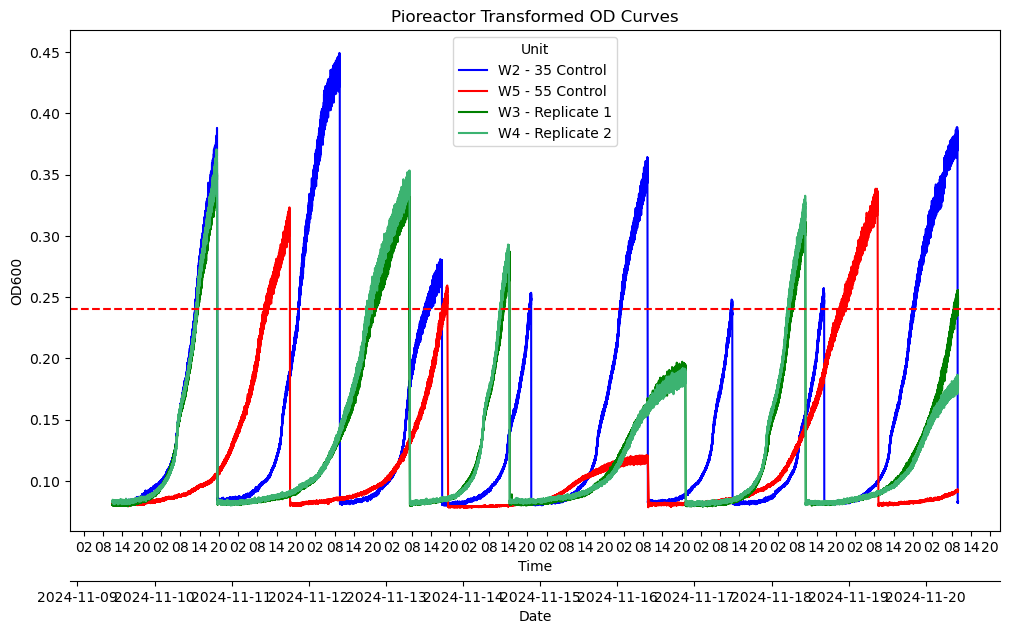

In [2]:
# Get the list of CSV files in the Downloads folder
csv_files = glob.glob(os.path.expanduser('~/Downloads/*.csv'))

if len(csv_files) == 0:
    csv_files = glob.glob('./od_logs/*.csv')

# Find the most recent file based on modification time
latest_csv = max(csv_files, key=os.path.getmtime)

# Load the latest CSV file
df = pl.read_csv(latest_csv).select("od_reading", "timestamp_localtime", "pioreactor_unit").rename({"od_reading": "OD600", "timestamp_localtime": "Time", "pioreactor_unit": "Unit"})

# If you want to load a specific CSV file, you can use the following line:
# df = pl.scan_csv(insert csv here).select("OD600", "Time", "Unit")

# Dictionary to map 'Pioreactor name' to new values
name_dict = {
    'worker2': 'W2 - 35 Control',
    'worker3': 'W3 - Replicate 1',
    'worker4': 'W4 - Replicate 2',
    'worker5': 'W5 - 55 Control'
}

optimal_controls = ["W2 - 35 Control"]
stressed_controls = ["W5 - 55 Control"]
controls = ["W5 - 55 Control", "W2 - 35 Control"]
replicates = ["W3 - Replicate 1", "W4 - Replicate 2"]

# Define the corresponding transformations for each condition
equations = {
    "W2 - 35 Control": (1.348628103, 0.077), 
    "W3 - Replicate 1": (2.073660771, .077), 
    "W4 - Replicate 2": (2.204291876, .077), 
    "W5 - 55 Control": (1.169484467, .077), 
}

threshold_od = 0.24  # Point after which we subculture

# Replace values in 'Pioreactor name' column using the dictionary
df = df.with_columns(pl.col("Unit").replace_strict(name_dict))

# Apply the equation
a = pl.col("Unit").replace_strict(equations).list.first()
b = pl.col("Unit").replace_strict(equations).list.last()
df = df.with_columns((pl.col("OD600") * a + b))

# Convert 'timestamp_localtime' to datetime format
df = df.with_columns(pl.col("Time").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S"))

# Filter out artifacts
df = df.filter(pl.col("Time") >= pl.col("Time").min().dt.offset_by("5m"))
df= df.with_columns((pl.col("Time").sub(pl.col("Time").first()).dt.total_seconds()/3600).alias("Hours"))
df = df.filter((pl.col("Unit").eq("W5 - 55 Control") & pl.col("Hours").ge(104.2) &  pl.col("Hours").le(104.4)).not_())

df = df.sort("Unit", "Hours")

# Plotting the growth curves using the new 'Transformed OD' column
hue_order = ["W2 - 35 Control", "W5 - 55 Control", "W3 - Replicate 1", "W4 - Replicate 2"]

f, ax = plt.subplots(figsize=(12, 6.5))
sns.lineplot(x="Time", y="OD600", hue="Unit", hue_order=hue_order,
             markersize=8, sizes=(1, 8), data=df.to_pandas(), ax=ax, palette=["blue", "red", "green", "mediumseagreen"])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
plt.axhline(y=threshold_od, color='r', linestyle='--')
# Set major ticks to every 6 hours
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax.set_xlabel("Time")

# Create a secondary x-axis for date display
secax = ax.secondary_xaxis(-0.1)
secax.xaxis.set_major_locator(mdates.DayLocator())
secax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
secax.set_xlabel("Date")
ax.set_title('Pioreactor Transformed OD Curves')
plt.show()

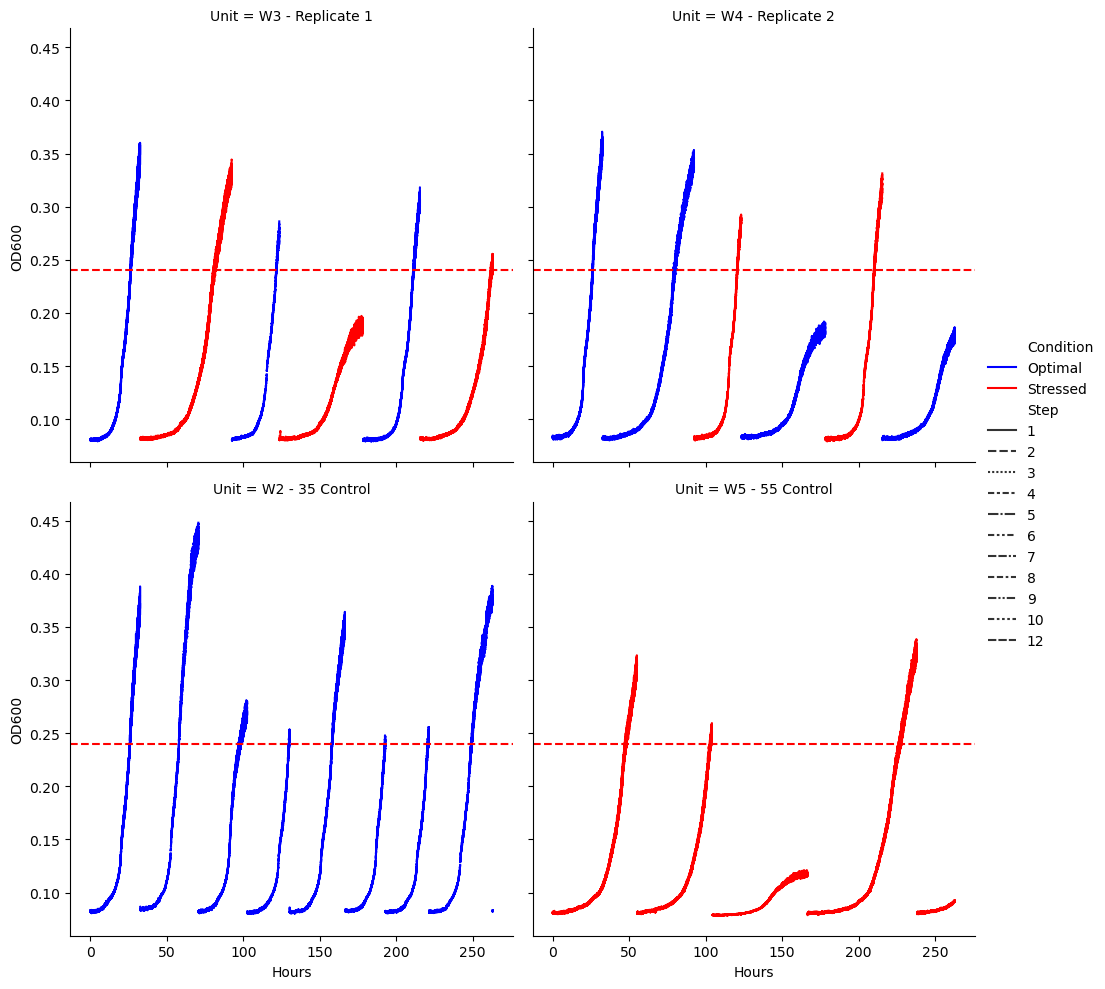

In [3]:
# Condition for incrementing 'step'
step_cond = (pl.col("OD600").shift(1) - pl.col("OD600") > 0.03)

# Use cumulative sum over the 'step_condition' to increment each time it's True
df = df.with_columns(pl.when(step_cond).then(1).otherwise(0).cum_sum().add(1).over(pl.col("Unit")).alias("Step"))

# Add condition to the df
df = df.with_columns(pl.when((pl.col("Step") % 2 == 1) & (pl.col("Unit").is_in(replicates)))
                     .then(pl.lit("Optimal"))
                     .otherwise(pl.when((pl.col("Step") % 2 == 0) & (pl.col("Unit").is_in(replicates)))
                                .then(pl.lit("Stressed"))
                                .otherwise(pl.when(pl.col("Unit").is_in(stressed_controls))
                                           .then(pl.lit("Stressed"))
                                           .otherwise(pl.when(pl.col("Unit").is_in(optimal_controls))
                                                      .then(pl.lit("Optimal")))))
                     .alias("Condition"))

# Discard the first 10 points in every step (because of subculture spike)
df = df.with_columns(pl.cum_count("OD600").over("Unit", "Step").alias("index")).filter(pl.col("index") > 5).drop("index")

# Plotting the growth curves using the new 'Transformed OD' column
col_order = ["W3 - Replicate 1", "W4 - Replicate 2", "W2 - 35 Control", "W5 - 55 Control"]
g = sns.relplot(x="Hours", y="OD600", hue="Condition", style="Step", col="Unit", col_wrap=2, col_order=col_order,
             markersize=8, sizes=(1, 8), data=df.to_pandas(), kind="line", hue_order=["Optimal", "Stressed"], palette=["blue", "red"])

for ax in g.axes.flatten():
    ax.axhline(y=threshold_od, color='r', linestyle='--')

plt.show()

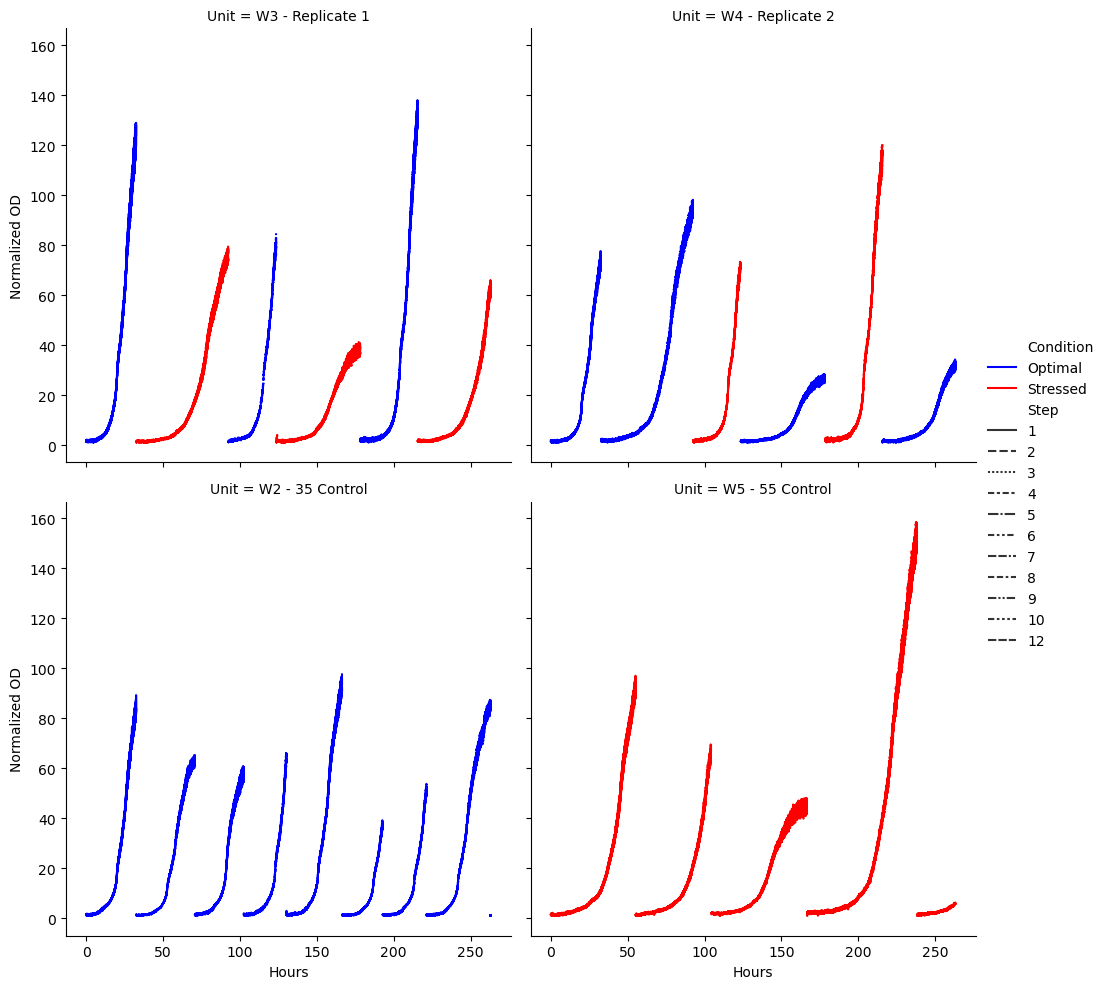

In [4]:
blank = 0.077

pioreactors = df.get_column("Unit").unique()

# Process data for each pioreactor
results = []
for pioreactor in pioreactors:
    pio_df = df.filter(pl.col("Unit") == pioreactor)
    pio_df = pio_df.with_columns(((pl.col("OD600") - blank)/(pl.col("OD600").min() - blank)).over("Step").alias("Normalized OD"))
    results.append(pio_df)

df = pl.concat(results)

# Plotting the growth curves using the new 'Transformed OD' column
col_order = ["W3 - Replicate 1", "W4 - Replicate 2", "W2 - 35 Control", "W5 - 55 Control"]
g = sns.relplot(x="Hours", y="Normalized OD", hue="Condition", style="Step", col="Unit", col_wrap=2, col_order=col_order,
             markersize=8, sizes=(1, 8), data=df.to_pandas(), kind="line", hue_order=["Optimal", "Stressed"], palette=["blue", "red"])

plt.show()

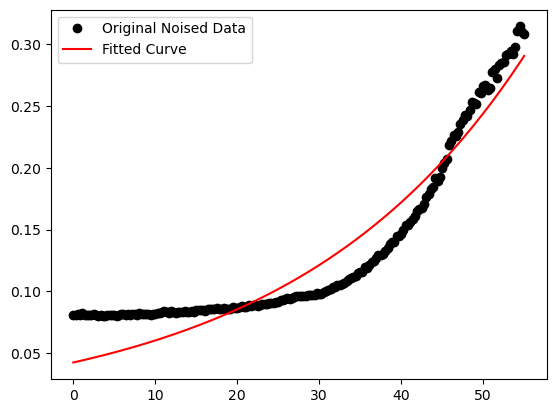

[0.04254353 0.03491622]


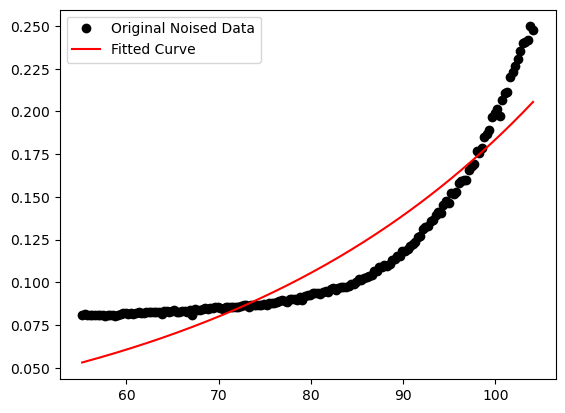

[0.01151072 0.02769225]


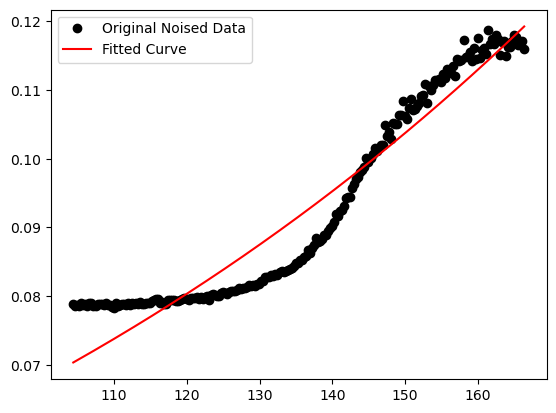

[0.02891721 0.00851601]


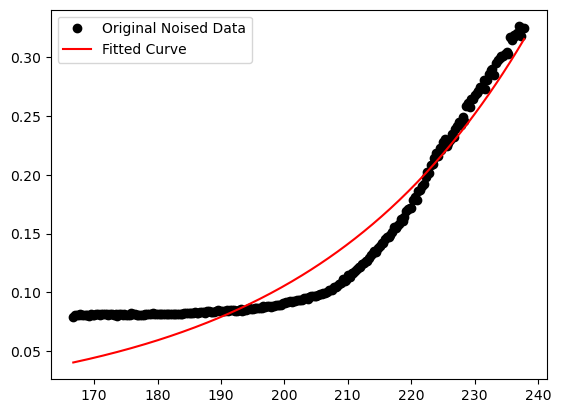

[0.0003229  0.02895091]


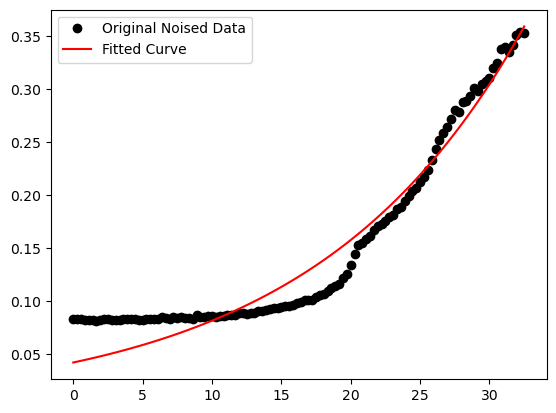

[0.04233568 0.06575785]


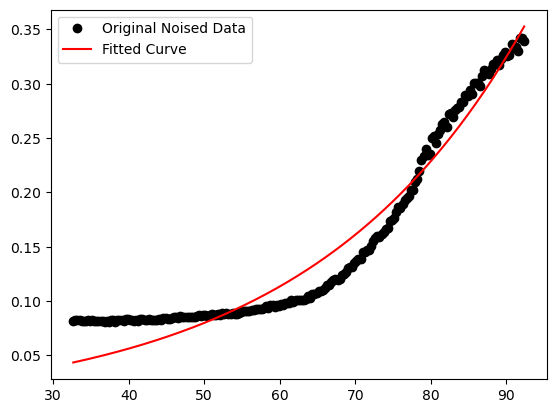

[0.01386711 0.03503509]


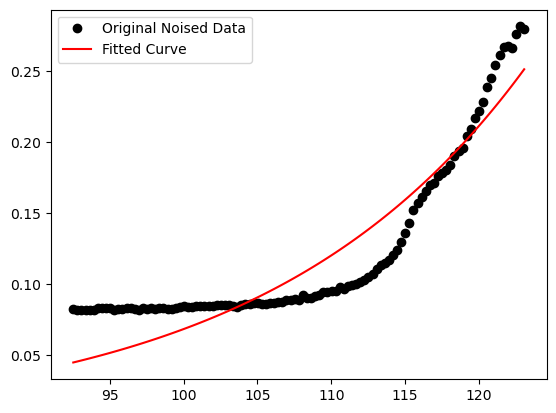

[0.00024263 0.05641537]


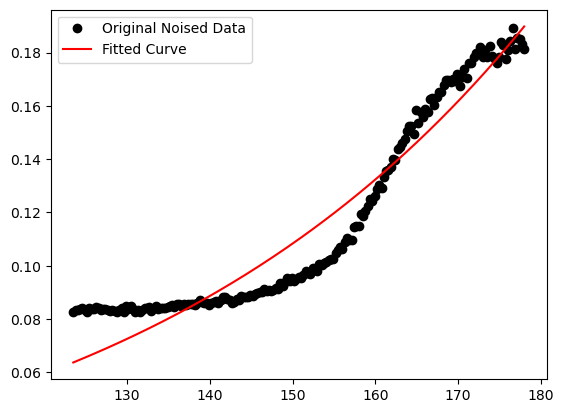

[0.00534028 0.0200654 ]


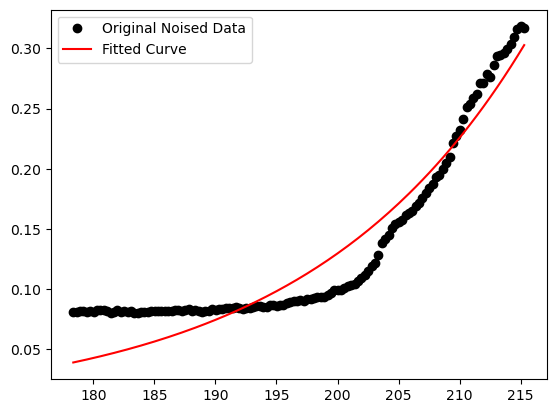

[1.97608437e-06 5.54573314e-02]


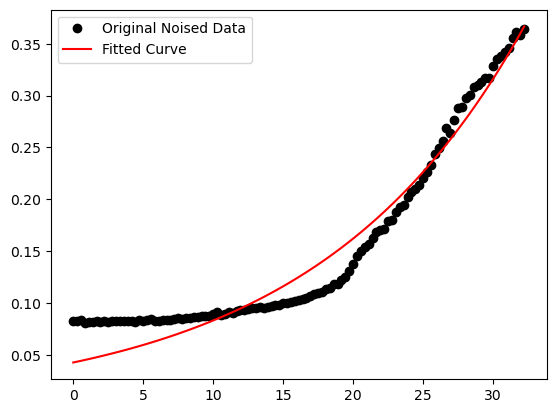

[0.04263473 0.06676592]


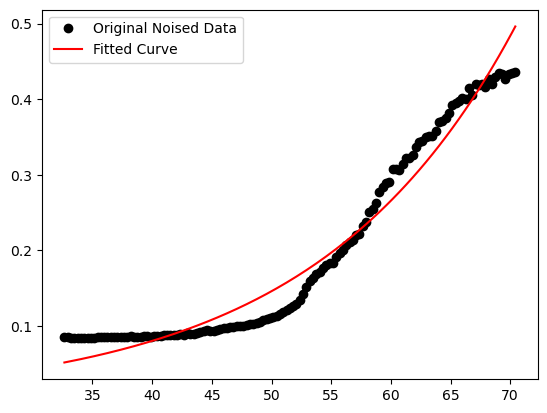

[0.00727189 0.05996335]


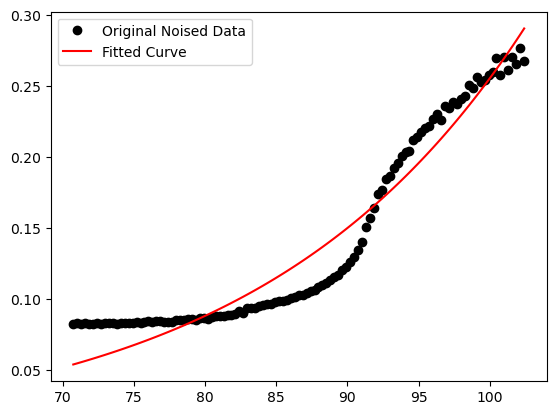

[0.0012345  0.05332167]


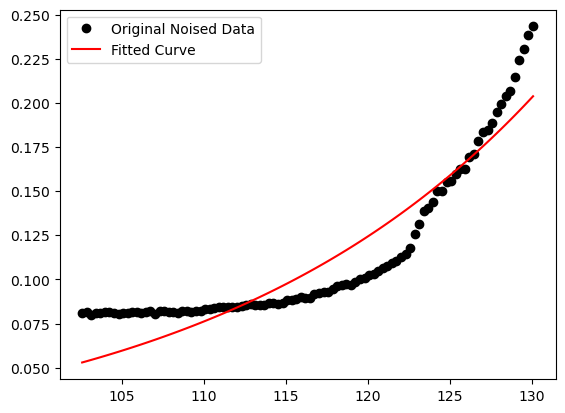

[0.0003468  0.04902891]


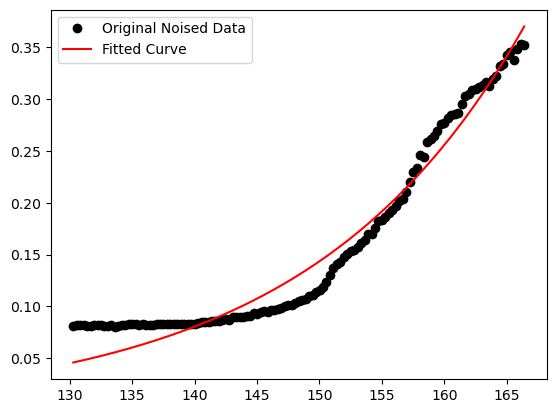

[2.48353140e-05 5.77478399e-02]


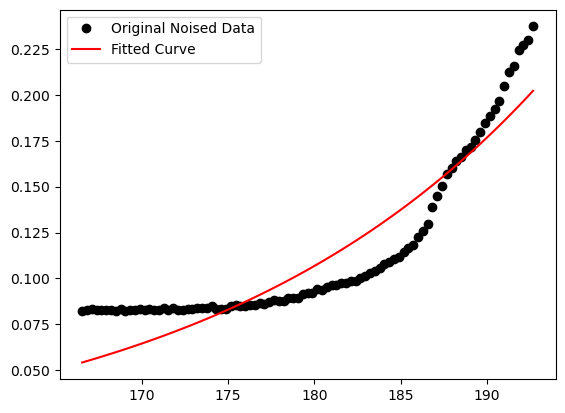

[1.22608252e-05 5.04031706e-02]


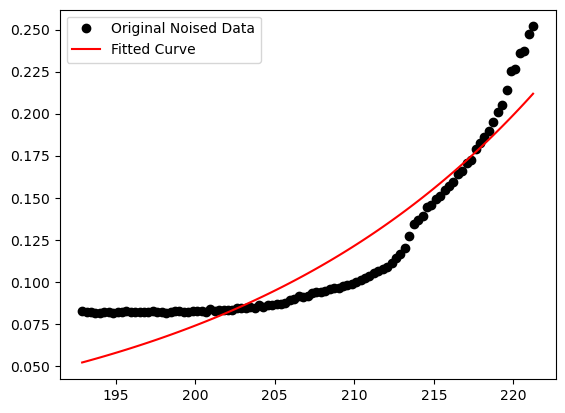

[3.62642889e-06 4.96108875e-02]


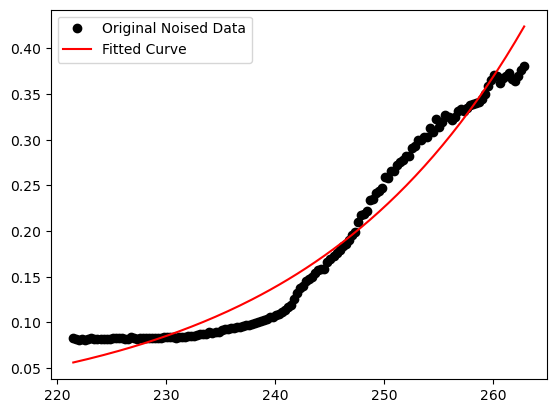

[1.12088368e-06 4.88644048e-02]


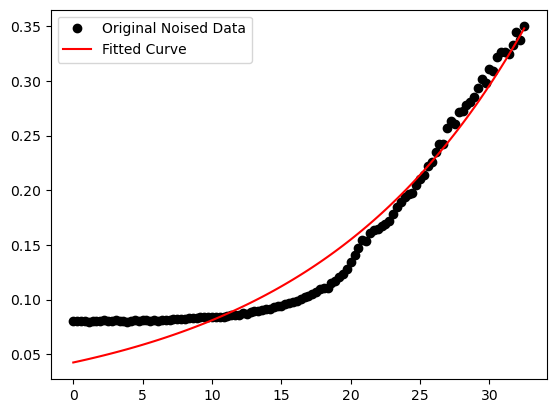

[0.04242116 0.06474906]


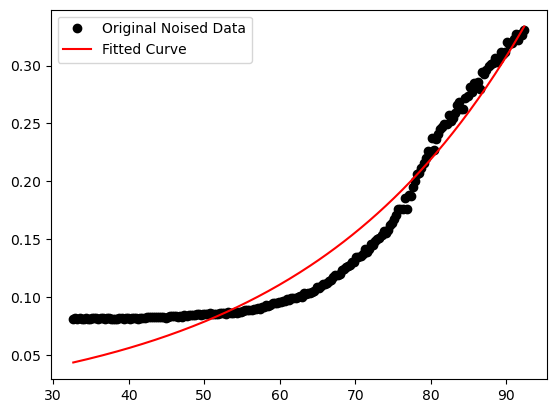

[0.01442583 0.03400788]


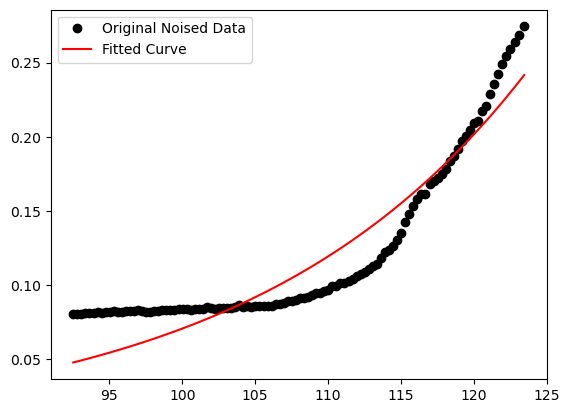

[0.00036888 0.05252723]


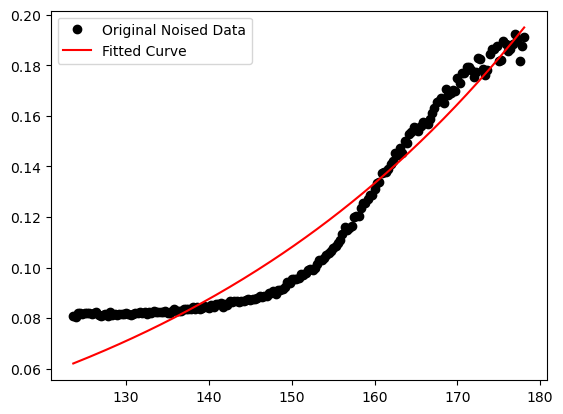

[0.00460752 0.02103327]


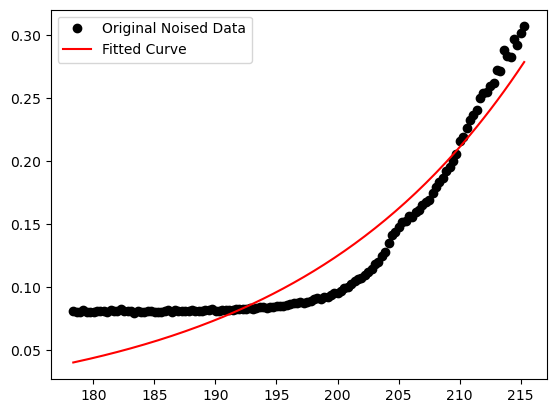

[3.41942057e-06 5.25242429e-02]


In [5]:
import scipy 

# Initialize storage for plot data
plot_data = {"Type": [], "Slope": [], "Condition": [], "Step": [], "Intercept": [], "Unit": []}
pioreactors = df.get_column("Unit").unique()

# Process data for each pioreactor
for pioreactor in pioreactors:
    pio_df = df.filter(pl.col("Unit") == pioreactor)

    # For each step except the one underway
    for step in pio_df.get_column("Step").unique()[:-1]:
        # Get the step data
        step_df = pio_df.filter(pl.col("Step") == step).sort("Hours").gather_every(200)

        # Fit a curve throguh it 
        
        import polars as pl
        import numpy as np
        from scipy.optimize import curve_fit
        import matplotlib.pyplot as plt
        
        # Extract columns into numpy arrays
        x = step_df["Hours"].to_numpy()
        y = step_df["OD600"].to_numpy()
        
        # calculate polynomial
        def exp(t, a, b):
            return a*np.exp(b*t)
            
        popt, pcov = scipy.optimize.curve_fit(exp,  x,  y, p0=(0.04, 0.06))
        
        plt.figure()
        plt.plot(x, y, 'ko', label="Original Noised Data")
        plt.plot(x, exp(x, *popt), 'r-', label="Fitted Curve")
        plt.legend()
        plt.show()
        print(popt)
        



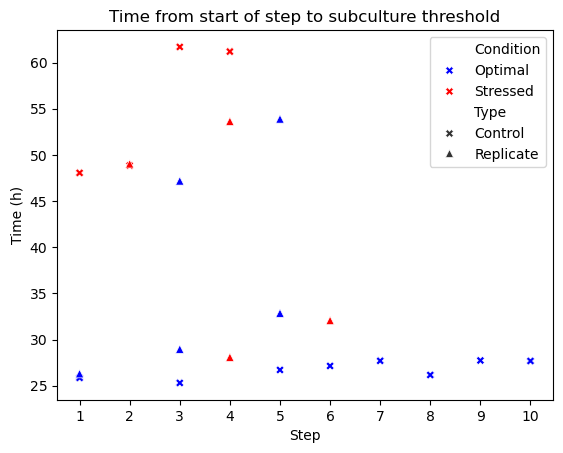

In [6]:
plot_df = {"Type": [], "Time (h)": [], "Condition": [], "Step":[]}
for pioreactor in pioreactors:
    pio_df = df.filter(pl.col("Unit").eq(pioreactor))
    
    for step in pio_df.get_column("Step").unique()[:-1]:
        step_df = pio_df.filter(pl.col("Step").eq(step)).sort("Time", descending=False)

        try:
            thresh_time = (step_df.with_columns((pl.col("OD600") - threshold_od).abs().alias("distance"))
                            .filter(pl.col("distance") == pl.col("distance").min())
                            .get_column("Time")[0])
            start_time = step_df.get_column("Time")[0]
            time_to_threshold = (thresh_time - start_time).total_seconds() / 3600
        except:
            continue
        
        plot_df["Time (h)"].append(time_to_threshold)
        plot_df["Step"].append(step)

        if "35" in pioreactor:
            plot_df["Type"].append("Control")
            plot_df["Condition"].append("Optimal")
        elif "55" in pioreactor:
            plot_df["Type"].append("Control")
            plot_df["Condition"].append("Stressed")
        elif "Replicate" in pioreactor:
            plot_df["Type"].append("Replicate")
            plot_df["Condition"].append("Optimal" if step % 2 == 1 else "Stressed")

# Plotting each pioreactor in a separate subplot
num_pioreactors = len(pioreactors)
plot_df = pl.from_dict(plot_df).to_pandas()
sns.scatterplot(plot_df, style="Type", x="Step", y="Time (h)", hue="Condition", hue_order=["Optimal", "Stressed"], palette=["blue", "red"], markers={"Replicate": "^", "Control": "X"})
plt.xticks(ticks=range(int(plot_df["Step"].min()), int(plot_df["Step"].max()) + 1))
plt.title("Time from start of step to subculture threshold")
plt.show()

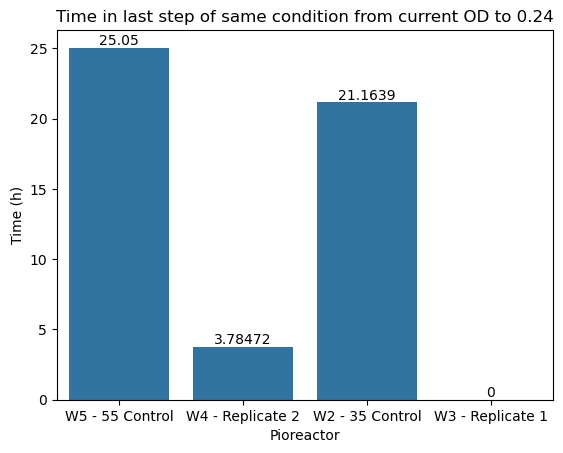

In [7]:
predict_od = 0.24
plot_df = {"Pioreactor": [], "Time (h)": []}
for pioreactor in pioreactors:
    pio_df = df.filter(pl.col("Unit").eq(pioreactor)).sort("Time", descending=False)

    steps = pio_df.get_column("Step").sort().unique().to_list()
    current_od = pio_df.filter(pl.col("Step").eq(steps[-1])).get_column("OD600")[-1]
    
    last_step = pio_df.filter(pl.col("Step").eq(steps[-3]))
    thresh_time = (last_step.with_columns((pl.col("OD600") - predict_od).abs().alias("distance"))
                        .filter(pl.col("distance") == pl.col("distance").min())
                        .get_column("Time")[0])
    
    time_in_last_step = (last_step.with_columns((pl.col("OD600") - current_od).abs().alias("distance"))
                        .filter(pl.col("distance") == pl.col("distance").min())
                        .get_column("Time")[0])
    
    time_to_threshold = (thresh_time - time_in_last_step).total_seconds() / 3600
    
    plot_df["Time (h)"].append(time_to_threshold)
    plot_df["Pioreactor"].append(pioreactor)


# Plotting each pioreactor in a separate subplot
num_pioreactors = len(pioreactors)
plot_df = pl.from_dict(plot_df).to_pandas()
ax = sns.barplot(plot_df, x="Pioreactor", y="Time (h)")
ax.bar_label(ax.containers[0], fontsize=10);
plt.title(f"Time in last step of same condition from current OD to {predict_od:.2f}")
plt.show()


In [8]:
predict_od = 0.45
plot_df = {"Pioreactor": [], "Time (h)": []}
for pioreactor in pioreactors:
    pio_df = df.filter(pl.col("Unit").eq(pioreactor)).sort("Time", descending=False)

    steps = pio_df.get_column("Step").sort().unique().to_list()
    current_od = pio_df.filter(pl.col("Step").eq(steps[-1])).get_column("OD600")[-1]
    
    last_step = pio_df.filter(pl.col("Step").eq(steps[-3]))
    thresh_time = (last_step.with_columns((pl.col("OD600") - predict_od).abs().alias("distance"))
                        .filter(pl.col("distance") == pl.col("distance").min())
                        .get_column("Time")[0])
    
    time_in_last_step = (last_step.with_columns((pl.col("OD600") - current_od).abs().alias("distance"))
                        .filter(pl.col("distance") == pl.col("distance").min())
                        .get_column("Time")[0])
    
    time_to_threshold = (thresh_time - time_in_last_step).total_seconds() / 3600

    #Add time to threshold to latest timestamp of current step
    predicted_time_at_threshold = pio_df.filter(pl.col("Step").eq(steps[-1])).get_column("Time")[-1] + (thresh_time - time_in_last_step)
    
    print(f"Predicted time to {predict_od:.2f} for {pioreactor}: {predicted_time_at_threshold}")


Predicted time to 0.45 for W5 - 55 Control: 2024-11-21 11:03:29
Predicted time to 0.45 for W4 - Replicate 2: 2024-11-20 13:47:34
Predicted time to 0.45 for W2 - 35 Control: 2024-11-21 07:50:24
Predicted time to 0.45 for W3 - Replicate 1: 2024-11-20 10:00:29
